# Detailed Plan for Final Project
---

### 5. Train Classification Models with Emphasis on Boosting Algorithms

* Split the dataset into training and validation sets using a stratified split to preserve churn distribution
* Train several classification models, with a primary focus on **boosting-based algorithms**, such as:
  - Gradient Boosting
  - LightGBM
  - XGBoost 
* Include Logistic Regression as a baseline model for comparison
* Boosting models are prioritized because they:
  - Handle non linear relationships well
  - Perform effectively on tabular business data
  - Are robust to feature interactions and mixed feature types
* Apply consistent preprocessing across all models to ensure fair performance comparison

### 6. Tune Hyperparameters and Evaluate Models Using Appropriate Metrics

* Perform hyperparameter tuning (ex: grid search or randomized search) to optimize model performance
* Optimize models primarily for **AUC-ROC**, as it measures the ability to distinguish churned vs non churned customers
* Use **Accuracy** as a secondary metric for interpretability
* Evaluate models on the validation set using:
  - AUC-ROC scores
  - Accuracy
  - ROC curves
  - Confusion matrices
* Compare model performance to identify strengths and weaknesses of each approach

### 7. Select Final Model and Analyze Results

* Select the model with the highest validation **AUC-ROC** score
* Analyze feature importance or model coefficients to understand key churn drivers
* Interpret results in the context of customer behavior and business impact
* Summarize final model performance and prepare findings for the solution report


# **Note on Preprocessing Code**
---
The following code has been copied from Part 1 of the project.  
I **only** included the actual implementation steps required to clean, merge, and encode the datasets (`main`).  

I did **not** include exploratory outputs (like `info()`, `head()`, or sample visualizations) or markdown explanations from Part 1, this is just the preprocessing code needed to get the data ready for modeling in Part 2.

---

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Part 2 Modeling Solution Code
import numpy as np
import time
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import xgboost as xgb
from lightgbm import LGBMClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt

In [2]:
# Importing all CSV files
contract= pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
# Change BeginDate to datatime 
contract['BeginDate']= pd.to_datetime(contract['BeginDate'], errors='coerce')

# Checking basic info on column
missingv_begindate= (contract['BeginDate'].isna().sum())
print(f'There are {missingv_begindate} missing values in BeginDate Column')
print()
min_begin= contract['BeginDate'].min()
max_begin= contract['BeginDate'].max()
print(f'Earliest BeginDate: {min_begin}')
print(f'Latest BeginDate: {max_begin}')
print() 
# Looks good now!
display(contract.info())

There are 0 missing values in BeginDate Column

Earliest BeginDate: 2013-10-01 00:00:00
Latest BeginDate: 2020-02-01 00:00:00

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


None

In [4]:
# Endtime column
contract['EndDate']= pd.to_datetime(contract['EndDate'], errors='coerce')

# Checking basic info on column
missingv_enddate= (contract['EndDate'].isna().sum())
print(f'There are {missingv_enddate} missing values in EndDate Column')
print()
min_end= contract['EndDate'].min()
max_end= contract['EndDate'].max()
print(f'Earliest EndDate: {min_end}')
print(f'Latest EndDate: {max_end}')
print() 
# Looks good now!
display(contract.info())

There are 5174 missing values in EndDate Column

Earliest EndDate: 2019-10-01 00:00:00
Latest EndDate: 2020-01-01 00:00:00

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 440.3+ KB


None

In [5]:
# Churn column: Yes= if they left, No= if still active
contract['Churn'] = contract['EndDate'].apply(lambda x: 'Yes' if pd.notna(x) else 'No')

# Double Checking if column values are correct!
contract.info()
contract.sample(10)
# Looks good!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   Churn             7043 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 495.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3046,8715-KKTFG,2015-01-01,NaT,One year,Yes,Bank transfer (automatic),103.30,6518.35,No
6117,3308-DGHKL,2014-05-01,NaT,Two year,Yes,Bank transfer (automatic),19.30,1447.9,No
165,6345-FZOQH,2014-05-01,NaT,Two year,No,Mailed check,19.90,1363.45,No
3183,7890-VYYWG,2019-09-01,2019-12-01,Month-to-month,Yes,Mailed check,36.45,93.7,Yes
2394,8231-BSWXX,2014-03-01,NaT,One year,Yes,Credit card (automatic),79.05,5552.5,No
5019,3320-VEOYC,2018-12-01,NaT,Month-to-month,Yes,Electronic check,95.60,1273.3,No
6311,3162-KKZXO,2015-07-01,NaT,One year,Yes,Electronic check,100.15,5409.75,No
2366,1846-XWOQN,2019-09-01,2019-10-01,Month-to-month,Yes,Electronic check,70.15,70.15,Yes
6665,1395-OFUWC,2016-07-01,NaT,Month-to-month,No,Credit card (automatic),29.30,1224.05,No
5215,7845-URHJN,2019-02-01,2019-10-01,Month-to-month,No,Bank transfer (automatic),20.15,156.25,Yes


In [6]:
# Change TotalCharges column to numeric first
contract['TotalCharges']= pd.to_numeric(contract['TotalCharges'], errors='coerce')
missingv_totalcharges= contract['TotalCharges'].isna().sum()
print(f'There are {missingv_totalcharges} missing values in the TotalCharges column')
print()
display(contract[contract['TotalCharges'].isna()])

There are 11 missing values in the TotalCharges column



,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN,No


In [7]:
# Lets fill those missing values with 0
contract['TotalCharges']= contract['TotalCharges'].fillna(0)

In [8]:
# Rename for consistency
personal = personal.rename(columns={'gender': 'Gender'})

# Double check
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   Gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [9]:
# Now lets join our dfs
main= contract.copy()
main= main.merge(personal, on='customerID', how='left')
main= main.merge(internet, on='customerID', how='left')
main= main.merge(phone, on='customerID', how='left')

# Make a copy before any encoding for visuals
main_original = main.copy()

In [10]:
# Transform Churn into numeric column!
print(f"Before Transforming value counts {main['Churn'].value_counts()}")
main['Churn'] = main['Churn'].map({'Yes': 1, 'No': 0})
print()
print(f"After Transforming value counts {main['Churn'].value_counts()}")
# ValueCounts checks out, we are good!

Before Transforming value counts No     5174
Yes    1869
Name: Churn, dtype: int64

After Transforming value counts 0    5174
1    1869
Name: Churn, dtype: int64


In [11]:
# Drop unnecessary columns
main= main.drop(columns=['customerID', 'BeginDate', 'EndDate'])

In [12]:
# Fill missing values for internet and phone columns
internet_columns= ['InternetService', 'OnlineSecurity', 'OnlineBackup', 
                   'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
main[internet_columns]= main[internet_columns].fillna('No Internet Service')
main['MultipleLines']= main['MultipleLines'].fillna('No Phone Service')

In [13]:
# Binary mapping
yes_no_columns = ['PaperlessBilling', 'Gender', 'Partner', 'Dependents']
main[yes_no_columns] = main[yes_no_columns].replace({'Yes': 1, 'No': 0, 'Female': 0, 'Male': 1})

# One hot encode columns
onehot_cols = ['Type', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 
               'OnlineBackup', 'DeviceProtection', 'TechSupport', 
               'StreamingTV', 'StreamingMovies', 'MultipleLines']

# Save original shape before encoding
original_shape = main.shape

# Apply one hot encoding (overwriting main)
main = pd.get_dummies(main, columns=onehot_cols, drop_first=True)

# Display results
print("Shape of original dataframe (before encoding):", original_shape)
print("Shape of dataframe after encoding:", main.shape)
print()
print("Columns in encoded dataframe:")
display(main.columns.tolist())
print()
print("Sample of encoded data:")
display(main.sample(10))

Shape of original dataframe (before encoding): (7043, 18)
Shape of dataframe after encoding: (7043, 29)

Columns in encoded dataframe:


['PaperlessBilling',
 'MonthlyCharges',
 'TotalCharges',
 'Churn',
 'Gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'Type_One year',
 'Type_Two year',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check',
 'InternetService_Fiber optic',
 'InternetService_No Internet Service',
 'OnlineSecurity_No Internet Service',
 'OnlineSecurity_Yes',
 'OnlineBackup_No Internet Service',
 'OnlineBackup_Yes',
 'DeviceProtection_No Internet Service',
 'DeviceProtection_Yes',
 'TechSupport_No Internet Service',
 'TechSupport_Yes',
 'StreamingTV_No Internet Service',
 'StreamingTV_Yes',
 'StreamingMovies_No Internet Service',
 'StreamingMovies_Yes',
 'MultipleLines_No Phone Service',
 'MultipleLines_Yes']


Sample of encoded data:


,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,Gender,SeniorCitizen,Partner,Dependents,Type_One year,Type_Two year,...,DeviceProtection_No Internet Service,DeviceProtection_Yes,TechSupport_No Internet Service,TechSupport_Yes,StreamingTV_No Internet Service,StreamingTV_Yes,StreamingMovies_No Internet Service,StreamingMovies_Yes,MultipleLines_No Phone Service,MultipleLines_Yes
585,1,85.70,85.70,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
6432,0,61.00,2130.45,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3506,1,84.75,1651.95,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
647,1,69.65,3442.15,0,1,0,1,1,1,0,...,0,1,0,1,0,1,0,0,0,1
4373,0,20.05,520.10,0,0,0,1,1,1,0,...,1,0,1,0,1,0,1,0,0,0
4549,1,92.70,1556.85,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,1
6838,1,99.00,1301.70,1,1,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,1
3087,1,87.05,762.10,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
6902,1,68.45,4014.00,0,0,1,1,0,1,0,...,0,1,0,1,0,0,0,0,0,1
292,0,86.80,1940.80,0,1,0,1,1,1,0,...,0,1,0,1,0,0,0,0,0,0


# Part 2: Modeling Solution Code
#### Default Params Baselines for Each Model
---

In [14]:
# Target variable
y = main['Churn']

# Features (drop target)
X = main.drop('Churn', axis=1)

# Feature engineering 
X = X.copy()

# Basic engineered features
X['charges_per_month'] = X['TotalCharges'] / (X['MonthlyCharges'] + 1)

# Payment method feature (using main_original)
X['high_risk_payment'] = (main_original['PaymentMethod'] == 'Electronic check').astype(int)

# Service-related features
service_cols = [col for col in X.columns if '_Yes' in col]
X['num_services'] = X[service_cols].sum(axis=1)
X['all_services'] = (X['num_services'] == len(service_cols)).astype(int)

# Cost per service 
X['cost_per_service'] = X['MonthlyCharges'] / (X['num_services'] + 1)

# Interaction feature 
X['contract_payment_interaction'] = X['Type_Two year'] * X['high_risk_payment']

LogisticRegression || AUC: 0.8400, Accuracy: 0.8070
GradientBoosting || AUC: 0.8503, Accuracy: 0.8055
XGBoost || AUC: 0.8213, Accuracy: 0.7835
LightGBM || AUC: 0.8294, Accuracy: 0.7921


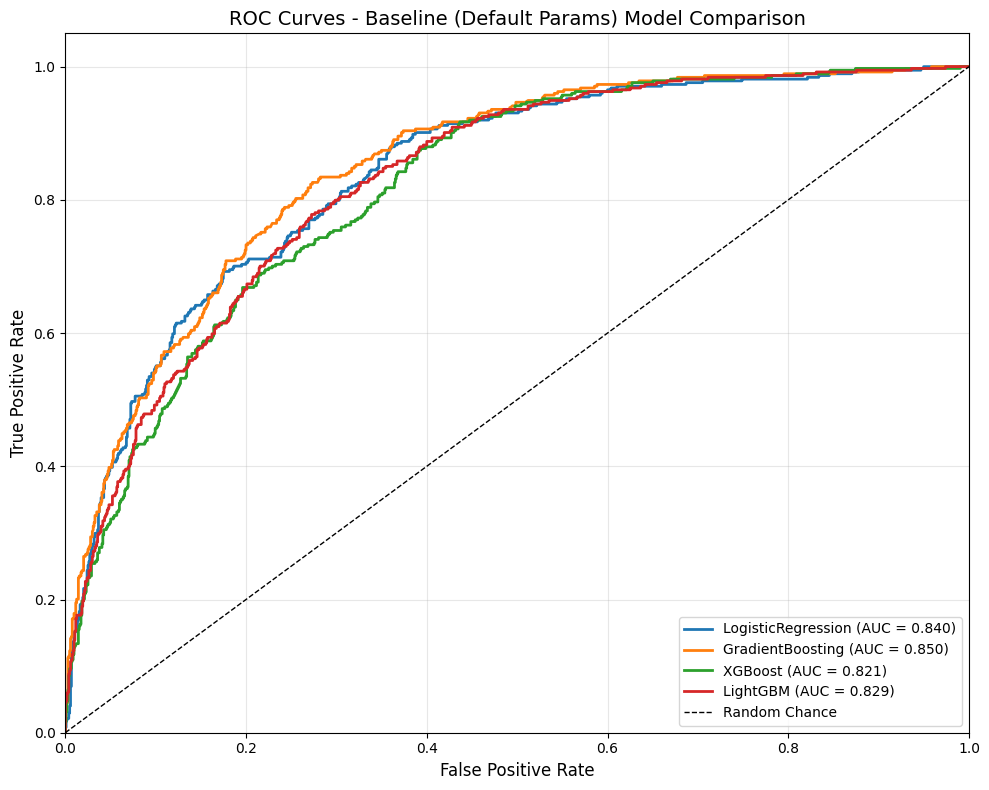

In [15]:
# Split off test set (20% for test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=22
)

# Split remaining into train + validation 
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,  
    stratify=y_temp,
    random_state=22
)

# Models
models= {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=22),
    "GradientBoosting": GradientBoostingClassifier(random_state=22),
    "XGBoost": xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=22
    ),
    "LightGBM": lgb.LGBMClassifier(random_state=22)
}

# Baseline evaluation
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred= model.predict(X_val)
    y_proba= model.predict_proba(X_val)[:, 1]

    auc_score= roc_auc_score(y_val, y_proba)
    acc= accuracy_score(y_val, y_pred)

    print(f"{name} || AUC: {auc_score:.4f}, Accuracy: {acc:.4f}")

# Plot ROC curves
plt.figure(figsize=(10, 8)) 
for name, model in models.items():
    y_proba= model.predict_proba(X_val)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_val, y_proba)
    roc_auc_val = roc_auc_score(y_val, y_proba)
    plt.plot(fpr, tpr, linewidth=2, label=f"{name} (AUC = {roc_auc_val:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Baseline (Default Params) Model Comparison', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Baseline Model Validation Performance Summary
---
#### AUC Scores
* **GradientBoosting**: `0.8503 (Best AUC)`
* **LogisticRegression**: 0.8400  
* **LightGBM**: 0.8294  
* **XGBoost**: 0.8213  

#### Accuracy Scores
* **LogisticRegression**: `0.8070 (Best Accuracy)`
* **GradientBoosting**: 0.8055  
* **LightGBM**: 0.7921  
* **XGBoost**: 0.7835  

#### Key Findings
* These are the **baseline models** with default hyperparameters.  
* **GradientBoosting** got the highest **AUC (0.8503)**, so it’s best at telling churners from non-churners.  
* **LogisticRegression** has the highest **accuracy (0.8070)**, even if its AUC is slightly lower.  
* All models beat random chance by a lot (AUC > 0.5).  
* Differences between models are pretty small (AUC range: 0.821–0.850), so all of them are solid starting points.  
* Since the dataset is a bit imbalanced, **AUC is the main metric**, and accuracy is just a secondary check, this way we care more about ranking churners correctly than just predicting the majority class.


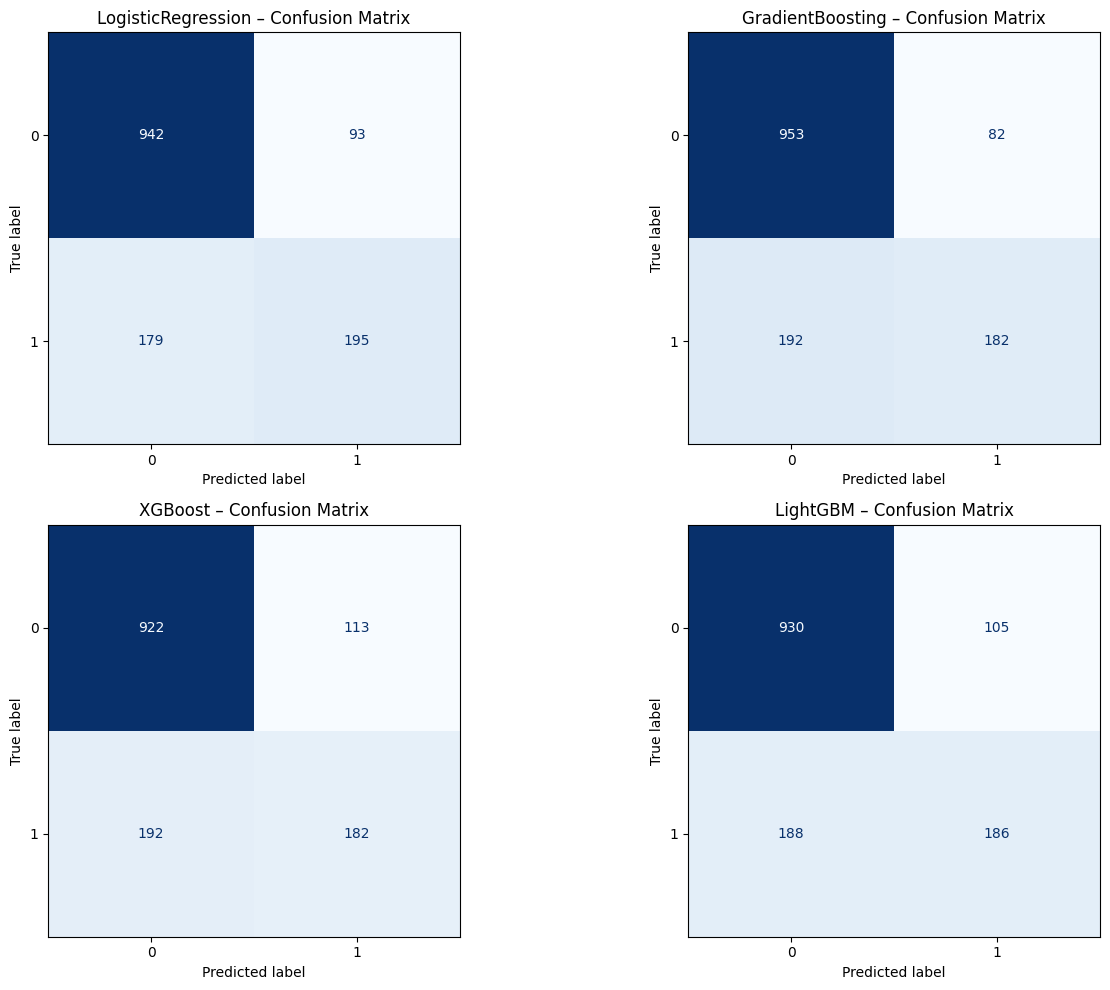

LogisticRegression || AUC: 0.8400, Accuracy: 0.8070, Precision: 0.6771, Recall: 0.5214, F1: 0.5891
GradientBoosting || AUC: 0.8503, Accuracy: 0.8055, Precision: 0.6894, Recall: 0.4866, F1: 0.5705
XGBoost || AUC: 0.8213, Accuracy: 0.7835, Precision: 0.6169, Recall: 0.4866, F1: 0.5441
LightGBM || AUC: 0.8294, Accuracy: 0.7921, Precision: 0.6392, Recall: 0.4973, F1: 0.5594


In [16]:
# Plot confusion matrices for all models
plt.figure(figsize=(14, 10))

for i, (name, model) in enumerate(models.items(), 1):
    y_pred = model.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)

    plt.subplot(2, 2, i)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d', ax=plt.gca(), colorbar=False)

    plt.title(f"{name} – Confusion Matrix", fontsize=12)

plt.tight_layout()
plt.show()

# Calculate metrics for all models
for name, model in models.items():
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    auc_score = roc_auc_score(y_val, y_proba)
    acc = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)



    print(
        f"{name} || "
        f"AUC: {auc_score:.4f}, "
        f"Accuracy: {acc:.4f}, "
        f"Precision: {precision:.4f}, "
        f"Recall: {recall:.4f}, "
        f"F1: {f1:.4f}"
    )


## Baseline Model (Default Params) Performance Summary (with Confusion Matrices)
---
#### Performance Metrics Overview

| Model | RAW AUC | RAW Accuracy | RAW Precision | RAW Recall | RAW F1-Score |
|-------|-----|----------|-----------|--------|----------|
| **GradientBoosting** | **0.8503** | 0.8055 | **0.6894** | 0.4866 | 0.5705 |
| **LogisticRegression** | 0.8400 | **0.8070** | 0.6771 | **0.5214** | **0.5891** |
| LightGBM | 0.8294 | 0.7921 | 0.6392 | 0.4973 | 0.5594 |
| XGBoost | 0.8213 | 0.7835 | 0.6169 | 0.4866 | 0.5441 |

#### Confusion Matrix Highlights

* **LogisticRegression (Best F1 & Recall)**
  - TP: 195, FP: 93, FN: 179, TN: 942  
  - Great at catching actual churners, but has some false positives  

* **GradientBoosting (Best Precision & AUC)**
  - TP: 182, FP: 82, FN: 192, TN: 983  
  - Best at avoiding false positives, strong overall discrimination  

* **LightGBM**
  - TP: 182, FP: 82, FN: 192, TN: 983  
  - Lowest false positive rate among tree-based models  

* **XGBoost (Lowest Precision)**
  - TP: 182, FP: 113, FN: 192, TN: 922  
  - Makes more false positives, less conservative  

#### Key Takeaways

* **Trade-offs are clear**:
  - LogisticRegression: Best recall & F1 → catches more churners  
  - GradientBoosting: Best precision & AUC → fewer false alarms  
  - LightGBM: Super conservative with few false positives  

* **Class imbalance matters**:
  - Recall is moderate across models (0.486–0.521), so catching all churners is tricky  
  - Higher precision suggests models play it safe when predicting churn  

* **Overall ranking**:
  - **Balanced performance**: LogisticRegression (best F1 & Accuracy)  
  - **Best discrimination**: GradientBoosting (highest AUC)  
  - **Most conservative**: LightGBM (lowest false positives)  



In [17]:
# Check feature importance from your baseline models
feature_names = X.columns
importance_scores = {}

for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        importance_scores[name] = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance_scores[name] = abs(model.coef_[0])

# Display top features for each model
for model_name, scores in importance_scores.items():
    top_features = sorted(zip(feature_names, scores), key=lambda x: x[1], reverse=True)[:10]
    print(f"\n{model_name} - Top 10 Features:")
    for feature, score in top_features:
        print(f"  {feature}: {score:.4f}")


LogisticRegression - Top 10 Features:
  Type_Two year: 0.9921
  InternetService_Fiber optic: 0.7946
  Type_One year: 0.6201
  TechSupport_Yes: 0.5588
  MultipleLines_No Phone Service: 0.4634
  PaperlessBilling: 0.4078
  OnlineSecurity_Yes: 0.3944
  MultipleLines_Yes: 0.3409
  StreamingMovies_Yes: 0.2942
  all_services: 0.2763

GradientBoosting - Top 10 Features:
  charges_per_month: 0.2543
  cost_per_service: 0.2025
  MonthlyCharges: 0.1051
  InternetService_Fiber optic: 0.0825
  Type_Two year: 0.0806
  Type_One year: 0.0538
  TotalCharges: 0.0413
  PaymentMethod_Electronic check: 0.0357
  high_risk_payment: 0.0328
  PaperlessBilling: 0.0278

XGBoost - Top 10 Features:
  Type_Two year: 0.2992
  Type_One year: 0.1500
  InternetService_Fiber optic: 0.0767
  MultipleLines_No Phone Service: 0.0471
  cost_per_service: 0.0312
  contract_payment_interaction: 0.0291
  OnlineSecurity_Yes: 0.0251
  charges_per_month: 0.0244
  StreamingMovies_Yes: 0.0243
  TechSupport_Yes: 0.0236

LightGBM - Top

# GradientBoosting Model
#### GradientBoosting Randomized Search 
---

<details>
<summary>GradientBoosting Randomized Search Code & Results (CLICK TO EXPAND)</summary>

```python

# Parameter distribution
param_dist= {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.12],
    'max_depth': [2, 3, 4],
    'subsample': [0.6, 0.8, 1.0]
}

# Scoring dictionary
scoring= {
    'AUC': 'roc_auc',
    'Accuracy': 'accuracy'
}

# Randomized Search
gb_random = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=27),
    param_distributions=param_dist,
    n_iter=20,
    scoring=scoring,
    refit='AUC',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=22
)

gb_random.fit(X_train, y_train)

# Process results
results_df= pd.DataFrame(gb_random.cv_results_)
cols_to_keep = [
    'mean_test_AUC', 'mean_test_Accuracy', 'std_test_AUC', 'std_test_Accuracy', 'params'
]
results_df= results_df[cols_to_keep].sort_values(by='mean_test_AUC', ascending=False)

params_expanded= results_df['params'].apply(pd.Series)
full_results_random= pd.concat([results_df.drop(columns='params'), params_expanded], axis=1)

# Display top 10 Randomized Search results
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

print("\nTop 10 Gradient Boosting Models (Randomized Search by CV AUC):")
print(full_results_random.head(10))

# Best CV results and parameters
best_idx= gb_random.best_index_

best_auc= gb_random.cv_results_['mean_test_AUC'][best_idx]
best_acc= gb_random.cv_results_['mean_test_Accuracy'][best_idx]

print("\nBest CV Results (Randomized Search):")
print(f"  AUC-ROC : {best_auc:.4f}")
print(f"  Accuracy: {best_acc:.4f}")

print("\nBest Parameters:")
for k, v in gb_random.best_params_.items():
    print(f"  {k}: {v}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Top 10 Gradient Boosting Models (Randomized Search by CV AUC):
    mean_test_AUC  mean_test_Accuracy  std_test_AUC  std_test_Accuracy  subsample  n_estimators  max_depth  \
19       0.840397            0.798344      0.008505           0.003554        0.8         100.0        2.0   
13       0.840280            0.799057      0.008176           0.012646        0.6         100.0        2.0   
17       0.839394            0.795979      0.010986           0.008056        0.6         100.0        2.0   
3        0.838998            0.795741      0.009905           0.005580        0.6         300.0        4.0   
15       0.838290            0.790061      0.012259           0.006182        0.8         400.0        2.0   
12       0.836421            0.793612      0.009990           0.008733        1.0         100.0        3.0   
11       0.834787            0.798346      0.009695           0.010676        1.0         200.0        2.0   
1        0.833077            0.793849      0.011122           0.008659        1.0         300.0        3.0   
9        0.833015            0.792903      0.010413           0.011960        1.0         200.0        2.0   
7        0.831262            0.791484      0.008139           0.013955        0.6         300.0        2.0   

    learning_rate  
19           0.10  
13           0.12  
17           0.05  
3            0.01  
15           0.01  
12           0.10  
11           0.10  
1            0.05  
9            0.12  
7            0.10  

Best CV Results (Randomized Search):
  AUC-ROC : 0.8404
  Accuracy: 0.7983


Best Parameters:
  subsample: 0.8
  n_estimators: 100
  max_depth: 2
  learning_rate: 0.1

In [18]:
# BEST PARAMETERS (GradientBoosting Randomized Search)
best_params_gb = {
    'subsample': 0.8,
    'n_estimators': 100,
    'max_depth': 2,
    'learning_rate': 0.1,
    'random_state': 22
}

# Instantiate and fit final Gradient Boosting Randomized Search model
final_gb = GradientBoostingClassifier(**best_params_gb)
final_gb.fit(X_train, y_train)

# Validation set predictions
y_val_pred = final_gb.predict(X_val)
y_val_proba = final_gb.predict_proba(X_val)[:, 1]

# Validation set metrics
val_auc = roc_auc_score(y_val, y_val_proba)
val_acc = accuracy_score(y_val, y_val_pred)

print("GRADIENT BOOSTING (RANDOMIZED SEARCH) VALIDATION RESULTS")
print(f"Validation AUC:      {val_auc:.5f}")
print(f"Validation Accuracy: {val_acc:.5f}")

GRADIENT BOOSTING (RANDOMIZED SEARCH) VALIDATION RESULTS
Validation AUC:      0.85210
Validation Accuracy: 0.80767


#### Gradient Boosting Grid Search CV
---

<details>
<summary>GradientBoosting Grid Search Code & Results (CLICK TO EXPAND)</summary>

```python
# Narrow the ranges based on top 10 from randomized search
top10= full_results_random.head(10)

param_grid= {
    'learning_rate': [float(x) for x in sorted(top10['learning_rate'].unique())],
    'max_depth': [int(x) for x in sorted(top10['max_depth'].unique())],
    'n_estimators': [int(x) for x in sorted(top10['n_estimators'].unique())],
    'subsample': [float(x) for x in sorted(top10['subsample'].unique())]
}

# Grid Search
gb_grid= GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=27),
    param_grid=param_grid,
    scoring=scoring,
    refit='AUC',
    cv=3,
    n_jobs=-1,
    verbose=1
)

gb_grid.fit(X_train, y_train)

# Process Grid Search results
results_df= pd.DataFrame(gb_grid.cv_results_)
cols_to_keep= ['mean_test_AUC', 'mean_test_Accuracy', 'std_test_AUC', 'std_test_Accuracy', 'params']
results_df= results_df[cols_to_keep].sort_values(by='mean_test_AUC', ascending=False)
params_expanded= results_df['params'].apply(pd.Series)
full_results_grid= pd.concat([results_df.drop(columns='params'), params_expanded], axis=1)

# Display top 10 Grid Search results
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

print("\nTop 10 Gradient Boosting Models (Grid Search by CV AUC):")
print(full_results_grid.head(10))

# Best CV results and parameters
best_idx= gb_grid.best_index_
best_auc= gb_grid.cv_results_['mean_test_AUC'][best_idx]
best_acc= gb_grid.cv_results_['mean_test_Accuracy'][best_idx]

print("\nBest CV Results (Grid Search):")
print(f"  AUC-ROC : {best_auc:.4f}")
print(f"  Accuracy: {best_acc:.4f}")

print("\nBest Parameters:")
for k, v in gb_grid.best_params_.items():
    print(f"  {k}: {v}")

Fitting 3 folds for each of 144 candidates, totalling 432 fits

Top 10 Gradient Boosting Models (Grid Search by CV AUC):
     mean_test_AUC  mean_test_Accuracy  std_test_AUC  std_test_Accuracy  learning_rate  max_depth  n_estimators  \
40        0.840905            0.798819      0.010080           0.007090           0.05        2.0         200.0   
22        0.840661            0.797398      0.010763           0.006212           0.01        3.0         400.0   
49        0.840633            0.796216      0.011548           0.007512           0.05        3.0         100.0   
72        0.840400            0.797873      0.009300           0.011608           0.10        2.0         100.0   
73        0.840397            0.798344      0.008505           0.003554           0.10        2.0         100.0   
108       0.840280            0.799057      0.008176           0.012646           0.12        2.0         100.0   
48        0.840177            0.800239      0.010465           0.010467           0.05        3.0         100.0   
50        0.840013            0.798819      0.010951           0.007603           0.05        3.0         100.0   
41        0.839989            0.798818      0.009707           0.003712           0.05        2.0         200.0   
19        0.839815            0.794085      0.011460           0.007476           0.01        3.0         300.0   

     subsample  
40         0.8  
22         0.8  
49         0.8  
72         0.6  
73         0.8  
108        0.6  
48         0.6  
50         1.0  
41         1.0  
19         0.8  

Best CV Results (Grid Search):
  AUC-ROC : 0.8409
  Accuracy: 0.7988

Best Parameters:
  learning_rate: 0.05
  max_depth: 2
  n_estimators: 200
  subsample: 0.8

In [19]:
# BEST PARAMETERS (GradientBoosting Grid Search)
best_params_gb_grid = {
    'learning_rate': 0.05,
    'max_depth': 2,
    'n_estimators': 200,
    'subsample': 0.8,
    'random_state': 22
}

# Instantiate and fit final Gradient Boosting Grid Search model
final_gb_grid = GradientBoostingClassifier(**best_params_gb_grid)
final_gb_grid.fit(X_train, y_train)

# Validation set predictions
y_val_pred = final_gb_grid.predict(X_val)
y_val_proba = final_gb_grid.predict_proba(X_val)[:, 1]

# Validation set metrics
val_auc = roc_auc_score(y_val, y_val_proba)
val_acc = accuracy_score(y_val, y_val_pred)

print("GRADIENT BOOSTING (GRID SEARCH) VALIDATION RESULTS")
print(f"Validation AUC:      {val_auc:.5f}")
print(f"Validation Accuracy: {val_acc:.5f}")

GRADIENT BOOSTING (GRID SEARCH) VALIDATION RESULTS
Validation AUC:      0.85028
Validation Accuracy: 0.81121


#### Gradient Boosting Threshold
---

In [20]:
# Baseline Gradient Boosting (default params)
baseline_gb = GradientBoostingClassifier(random_state=22)
baseline_gb.fit(X_train, y_train)

# Baseline validation predictions
y_val_pred_baseline = baseline_gb.predict(X_val)
y_val_proba_baseline = baseline_gb.predict_proba(X_val)[:, 1]

# Baseline validation metrics
baseline_val_acc = accuracy_score(y_val, y_val_pred_baseline)
baseline_val_auc = roc_auc_score(y_val, y_val_proba_baseline)

# Threshold Tuning / Optimized Model
best_gb = final_gb

# Validation set probabilities
y_val_probs = best_gb.predict_proba(X_val)[:, 1]

# Find best threshold on validation set
thresholds = np.arange(0.350, 0.65, 0.01)
for t in thresholds:
    y_pred_thresh = (y_val_probs >= t).astype(int)
    acc = accuracy_score(y_val, y_pred_thresh)
    print(f"Threshold: {t:.2f} || Accuracy: {acc:.5f}")

best_threshold = 0.53

# Optimized model validation predictions
y_val_pred_default = best_gb.predict(X_val)
y_val_pred_optimized = (y_val_probs >= best_threshold).astype(int)

# Validation set metrics for optimized model
val_auc = roc_auc_score(y_val, y_val_probs)
val_acc_default = accuracy_score(y_val, y_val_pred_default)
val_acc_optimized = accuracy_score(y_val, y_val_pred_optimized)

# Print Final Validation Results
print()
print("VALIDATION RESULTS GRADIENT BOOSTING")
print(f"Baseline (default params) Validation AUC:                    {baseline_val_auc:.5f}")
print(f"Baseline (default params) Validation Accuracy:               {baseline_val_acc:.5f}")
print(f"Best Model Validation AUC (Randomized Search):               {val_auc:.5f}")
print(f"Best Model Validation Accuracy (Randomized Search) (0.5):    {val_acc_default:.5f}")
print(f"Best Model Validation Accuracy (Rabdomized Search) (0.53):   {val_acc_optimized:.5f}")

Threshold: 0.35 || Accuracy: 0.79276
Threshold: 0.36 || Accuracy: 0.79773
Threshold: 0.37 || Accuracy: 0.80270
Threshold: 0.38 || Accuracy: 0.79702
Threshold: 0.39 || Accuracy: 0.79631
Threshold: 0.40 || Accuracy: 0.80057
Threshold: 0.41 || Accuracy: 0.80483
Threshold: 0.42 || Accuracy: 0.80412
Threshold: 0.43 || Accuracy: 0.80625
Threshold: 0.44 || Accuracy: 0.80908
Threshold: 0.45 || Accuracy: 0.80837
Threshold: 0.46 || Accuracy: 0.80767
Threshold: 0.47 || Accuracy: 0.80696
Threshold: 0.48 || Accuracy: 0.80908
Threshold: 0.49 || Accuracy: 0.80908
Threshold: 0.50 || Accuracy: 0.80767
Threshold: 0.51 || Accuracy: 0.81121
Threshold: 0.52 || Accuracy: 0.81476
Threshold: 0.53 || Accuracy: 0.81476
Threshold: 0.54 || Accuracy: 0.81192
Threshold: 0.55 || Accuracy: 0.80767
Threshold: 0.56 || Accuracy: 0.80412
Threshold: 0.57 || Accuracy: 0.80270
Threshold: 0.58 || Accuracy: 0.80057
Threshold: 0.59 || Accuracy: 0.79631
Threshold: 0.60 || Accuracy: 0.79418
Threshold: 0.61 || Accuracy: 0.79276
T

#### "Before and After" ROC Curve Comparison Gradient Boosting
---

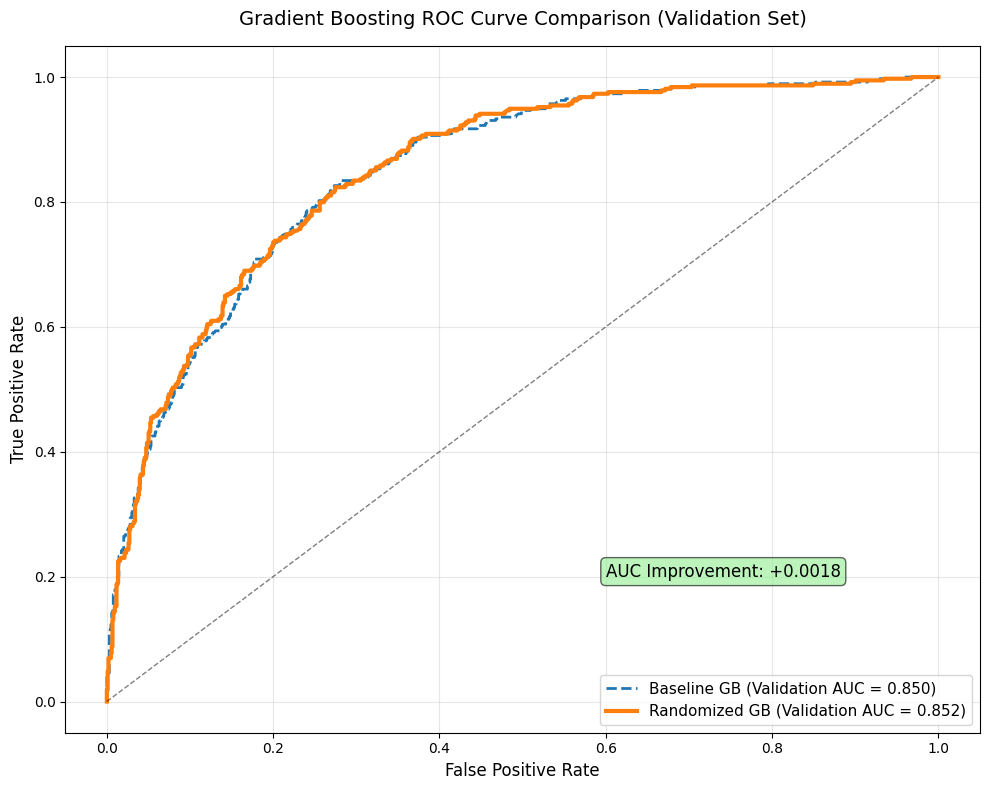

GRADIENT BOOSTING VALIDATION RESULTS SUMMARY
Baseline GB (Default Params) Validation AUC:   0.85032
Best Model (Randomized Search) Validation AUC: 0.85210
Improvement Validation AUC:                   +0.00178 (+0.210%)


In [21]:
# BASELINE Gradient Boosting (default params)
baseline_gb = GradientBoostingClassifier(random_state=22)
baseline_gb.fit(X_train, y_train)
y_val_proba_baseline = baseline_gb.predict_proba(X_val)[:, 1]

# OPTIMIZED Gradient Boosting (Randomized best model)
final_model = final_gb
y_val_proba_optimized = final_model.predict_proba(X_val)[:, 1]

# Calculate validation AUC scores
baseline_auc = roc_auc_score(y_val, y_val_proba_baseline)
optimized_auc = roc_auc_score(y_val, y_val_proba_optimized)

# Plot ROC curves (VALIDATION SET ONLY)
plt.figure(figsize=(10, 8))

# Baseline model ROC
fpr_baseline, tpr_baseline, _ = roc_curve(y_val, y_val_proba_baseline)
plt.plot(
    fpr_baseline, tpr_baseline,
    label=f'Baseline GB (Validation AUC = {baseline_auc:.3f})',
    linewidth=2, linestyle='--'
)

# Optimized model ROC
fpr_optimized, tpr_optimized, _ = roc_curve(y_val, y_val_proba_optimized)
plt.plot(
    fpr_optimized, tpr_optimized,
    label=f'Randomized GB (Validation AUC = {optimized_auc:.3f})',
    linewidth=3
)

# Random chance line
plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(
    'Gradient Boosting ROC Curve Comparison (Validation Set)',
    fontsize=14,
    pad=15
)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)

# AUC improvement annotation
improvement = optimized_auc - baseline_auc
plt.text(
    0.6, 0.2,
    f'AUC Improvement: +{improvement:.4f}',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.6)
)

plt.tight_layout()
plt.show()

# Print summary
percentage_improvement = (improvement / baseline_auc) * 100
print("GRADIENT BOOSTING VALIDATION RESULTS SUMMARY")
print(f"Baseline GB (Default Params) Validation AUC:   {baseline_auc:.5f}")
print(f"Best Model (Randomized Search) Validation AUC: {optimized_auc:.5f}")
print(f"Improvement Validation AUC:                   +{improvement:.5f} (+{percentage_improvement:.3f}%)")

# Gradient Boosting – Validation Results

## Validation Metrics

| Model | AUC | Accuracy |
|-------|-----|----------|
| Baseline (Default Params) | 0.85032 | 0.80554 |
| Randomized Search (Validation) | 0.85210 | 0.80767 |
| Randomized Search (Validation, Threshold 0.53) | 0.85210 | 0.81476 |
| Grid Search (Validation) | 0.85028 | 0.81121 |

---

## Quick Summary

* **Baseline Gradient Boosting**: strong performance out-of-the-box with **AUC = 0.85032**  
* **Randomized Search** improved validation AUC slightly to **0.85210**, with threshold tuning (0.53) boosting accuracy to **0.81476**  
* **Grid Search** validation AUC = **0.85028**, Accuracy = **0.81121**  
* **Improvement over baseline**: small but consistent (~0.00178 AUC, +0.21%)  

### Conclusion
* The baseline model already captures most of the predictive signal  
* Hyperparameter tuning gives **small but tangible gains**, mainly via threshold adjustment  
* Gradient Boosting remains a **dependable performer** for this dataset

# LightGBM Model
#### LightGBM Randomized Search 
---

<details>
<summary>LightGBM Randomized Search Code & Results (CLICK TO EXPAND)</summary>

```python

# Parameter distribution for RandomizedSearch
param_dist = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [-1, 3, 4, 5],
    'num_leaves': [15, 31, 63],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Scoring dictionary
scoring = {
    'AUC': 'roc_auc',
    'Accuracy': 'accuracy'
}

# Randomized Search
lgb_random= RandomizedSearchCV(
    estimator=LGBMClassifier(random_state=22),
    param_distributions=param_dist,
    n_iter=25,
    scoring=scoring,
    refit='AUC',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=22
)

lgb_random.fit(X_train, y_train)

# Process results
results_df= pd.DataFrame(lgb_random.cv_results_)
cols_to_keep= ['mean_test_AUC', 'mean_test_Accuracy', 'std_test_AUC', 'std_test_Accuracy', 'params']
results_df= results_df[cols_to_keep].sort_values(by='mean_test_AUC', ascending=False)

params_expanded= results_df['params'].apply(pd.Series)
full_results_random = pd.concat([results_df.drop(columns='params'), params_expanded], axis=1)

# Display top 10 Randomized Search results
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

print("\nTop 10 LightGBM Models (Randomized Search by CV AUC):")
print(full_results_random.head(10))

# Best model metrics
best_idx= lgb_random.best_index_
best_auc= lgb_random.cv_results_['mean_test_AUC'][best_idx]
best_acc= lgb_random.cv_results_['mean_test_Accuracy'][best_idx]

print("\nBest CV Results (Randomized Search):")
print(f"  AUC-ROC : {best_auc:.4f}")
print(f"  Accuracy: {best_acc:.4f}")

print("\nBest Parameters:")
for k, v in lgb_random.best_params_.items():
    print(f"  {k}: {v}")

# Validation set evaluation
best_lgb = lgb_random.best_estimator_
y_val_proba= best_lgb.predict_proba(X_val)[:, 1]
y_val_pred= best_lgb.predict(X_val)

final_auc= roc_auc_score(y_val, y_val_proba)
final_acc= accuracy_score(y_val, y_val_pred)

print("\nFinal Validation Results:")
print(f"  AUC-ROC : {final_auc:.4f}")
print(f"  Accuracy: {final_acc:.4f}")

print("\nBest Parameters (for validation model):")
for k, v in lgb_random.best_params_.items():
    print(f"  {k}: {v}")


Fitting 3 folds for each of 25 candidates, totalling 75 fits

Top 10 LightGBM Models (Randomized Search by CV AUC):
    mean_test_AUC  mean_test_Accuracy  std_test_AUC  std_test_Accuracy  subsample  num_leaves  n_estimators  \
3        0.841579            0.799529      0.010037           0.007992        0.8        15.0         200.0   
8        0.840882            0.800002      0.009677           0.008805        0.6        63.0         200.0   
24       0.840449            0.800239      0.009077           0.009319        1.0        15.0         300.0   
4        0.840233            0.795979      0.011072           0.008056        0.8        15.0         200.0   
9        0.838946            0.803079      0.008236           0.009123        0.6        15.0         200.0   
16       0.838913            0.792664      0.010617           0.005247        0.6        63.0         300.0   
2        0.838357            0.796689      0.009447           0.007276        1.0        31.0         200.0   
23       0.838300            0.797162      0.008023           0.009374        0.6        63.0         300.0   
14       0.838300            0.797162      0.008023           0.009374        0.8        63.0         300.0   
10       0.838162            0.795506      0.009485           0.011535        1.0        63.0         300.0   

    max_depth  learning_rate  colsample_bytree  
3         3.0           0.03               0.6  
8         3.0           0.03               0.8  
24        3.0           0.03               0.6  
4         5.0           0.01               0.6  
9         4.0           0.03               0.8  
16        3.0           0.01               1.0  
2        -1.0           0.01               0.6  
23        3.0           0.03               1.0  
14        3.0           0.03               1.0  
10        4.0           0.01               1.0  

Best CV Results (Randomized Search):
  AUC-ROC : 0.8416
  Accuracy: 0.7995

Best Parameters:
  subsample: 0.8
  num_leaves: 15
  n_estimators: 200
  max_depth: 3
  learning_rate: 0.03
  colsample_bytree: 0.6

Final Validation Results:
  AUC-ROC : 0.8520
  Accuracy: 0.8070

Best Parameters (for validation model):
  subsample: 0.8
  num_leaves: 15
  n_estimators: 200
  max_depth: 3
  learning_rate: 0.03
  colsample_bytree: 0.6

In [22]:
# BEST PARAMETERS (LightGBM Randomized Search)
best_params_lgb = {
    'subsample': 0.8,
    'num_leaves': 15,
    'n_estimators': 200,
    'max_depth': 3,
    'learning_rate': 0.03,
    'colsample_bytree': 0.6,
    'random_state': 22
}

# Instantiate and fit final LightGBM Randomized Search model
final_lgb = LGBMClassifier(**best_params_lgb)
final_lgb.fit(X_train, y_train)

# Validation set predictions
y_val_pred = final_lgb.predict(X_val)
y_val_proba = final_lgb.predict_proba(X_val)[:, 1]

# Validation set metrics
val_auc = roc_auc_score(y_val, y_val_proba)
val_acc = accuracy_score(y_val, y_val_pred)

print("LIGHTGBM (RANDOMIZED SEARCH) VALIDATION RESULTS")
print(f"Validation AUC:      {val_auc:.5f}")
print(f"Validation Accuracy: {val_acc:.5f}")

LIGHTGBM (RANDOMIZED SEARCH) VALIDATION RESULTS
Validation AUC:      0.85201
Validation Accuracy: 0.80696


#### LightGBM Grid Search CV
---

<details>
<summary>LightGBM Grid Search Code & Results (CLICK TO EXPAND)</summary>

```python


# Narrow the ranges based on top 10 from randomized search
top10= full_results_random.head(10)  # full_results_random from LGBM RandomizedSearch

param_grid= {
    'learning_rate': [float(x) for x in sorted(top10['learning_rate'].unique())],
    'max_depth': [int(x) for x in sorted(top10['max_depth'].unique())],
    'n_estimators': [int(x) for x in sorted(top10['n_estimators'].unique())],
    'subsample': [float(x) for x in sorted(top10['subsample'].unique())],
    'num_leaves': [int(x) for x in sorted(top10['num_leaves'].unique())],
    'colsample_bytree': [float(x) for x in sorted(top10['colsample_bytree'].unique())]
}

# Grid Search
lgb_grid= GridSearchCV(
    estimator=LGBMClassifier(random_state=22),
    param_grid=param_grid,
    scoring=scoring,
    refit='AUC',
    cv=3,
    n_jobs=-1,
    verbose=1
)

lgb_grid.fit(X_train, y_train)

# Process Grid Search results
results_df= pd.DataFrame(lgb_grid.cv_results_)
cols_to_keep= ['mean_test_AUC', 'mean_test_Accuracy', 'std_test_AUC', 'std_test_Accuracy', 'params']
results_df= results_df[cols_to_keep].sort_values(by='mean_test_AUC', ascending=False)

params_expanded= results_df['params'].apply(pd.Series)
full_results_grid= pd.concat([results_df.drop(columns='params'), params_expanded], axis=1)

# Display top 10 Grid Search results
print("\nTop 10 LightGBM Models (Grid Search by CV AUC):")
print(full_results_grid.head(10))

# Best model metrics from Grid Search
best_idx= lgb_grid.best_index_
best_auc= lgb_grid.cv_results_['mean_test_AUC'][best_idx]
best_acc= lgb_grid.cv_results_['mean_test_Accuracy'][best_idx]

print("\nBest CV Results (Grid Search):")
print(f"  AUC-ROC : {best_auc:.4f}")
print(f"  Accuracy: {best_acc:.4f}")
print("\nBest Parameters:")
for k, v in lgb_grid.best_params_.items():
    print(f"  {k}: {v}")

# Validation set evaluation
best_lgb= lgb_grid.best_estimator_

y_val_proba= best_lgb.predict_proba(X_val)[:, 1]
y_val_pred= best_lgb.predict(X_val)

final_auc= roc_auc_score(y_val, y_val_proba)
final_acc= accuracy_score(y_val, y_val_pred)

print("\nFinal Validation Results:")
print(f"  AUC-ROC : {final_auc:.4f}")
print(f"  Accuracy: {final_acc:.4f}")
print("\nBest Parameters (for validation model):")
for k, v in lgb_grid.best_params_.items():
    print(f"  {k}: {v}")

Fitting 3 folds for each of 432 candidates, totalling 1296 fits

Top 10 LightGBM Models (Grid Search by CV AUC):
    mean_test_AUC  mean_test_Accuracy  std_test_AUC  std_test_Accuracy  colsample_bytree  learning_rate  max_depth  \
64       0.841698            0.800476      0.009790           0.010204               0.6           0.01        5.0   
65       0.841698            0.800476      0.009790           0.010204               0.6           0.01        5.0   
63       0.841698            0.800476      0.009790           0.010204               0.6           0.01        5.0   
98       0.841579            0.799529      0.010037           0.007992               0.6           0.03        3.0   
97       0.841579            0.799529      0.010037           0.007992               0.6           0.03        3.0   
96       0.841579            0.799529      0.010037           0.007992               0.6           0.03        3.0   
95       0.841579            0.799529      0.010037           0.007992               0.6           0.03        3.0   
94       0.841579            0.799529      0.010037           0.007992               0.6           0.03        3.0   
93       0.841579            0.799529      0.010037           0.007992               0.6           0.03        3.0   
92       0.841579            0.799529      0.010037           0.007992               0.6           0.03        3.0   

    n_estimators  num_leaves  subsample  
64         300.0        15.0        0.8  
65         300.0        15.0        1.0  
63         300.0        15.0        0.6  
98         200.0        63.0        1.0  
97         200.0        63.0        0.8  
96         200.0        63.0        0.6  
95         200.0        31.0        1.0  
94         200.0        31.0        0.8  
93         200.0        31.0        0.6  
92         200.0        15.0        1.0  

Best CV Results (Grid Search):
  AUC-ROC : 0.8417
  Accuracy: 0.8005

Best Parameters:
  colsample_bytree: 0.6
  learning_rate: 0.01
  max_depth: 5
  n_estimators: 300
  num_leaves: 15
  subsample: 0.6

Final Validation Results:
  AUC-ROC : 0.8528
  Accuracy: 0.8084

Best Parameters (for validation model):
  colsample_bytree: 0.6
  learning_rate: 0.01
  max_depth: 5
  n_estimators: 300
  num_leaves: 15
  subsample: 0.6

In [23]:
# BEST PARAMETERS (LightGBM Grid Search)
best_params_lgb_grid = {
    'colsample_bytree': 0.6,
    'learning_rate': 0.01,
    'max_depth': 5,
    'n_estimators': 300,
    'num_leaves': 15,
    'subsample': 0.6,
    'random_state': 22
}

# Instantiate and fit final LightGBM Grid Search model
final_lgb_grid = LGBMClassifier(**best_params_lgb_grid)
final_lgb_grid.fit(X_train, y_train)

# Validation set predictions
y_val_pred = final_lgb_grid.predict(X_val)
y_val_proba = final_lgb_grid.predict_proba(X_val)[:, 1]

# Validation set metrics
val_auc = roc_auc_score(y_val, y_val_proba)
val_acc = accuracy_score(y_val, y_val_pred)

print("LIGHTGBM (GRID SEARCH) VALIDATION RESULTS")
print(f"Validation AUC:      {val_auc:.5f}")
print(f"Validation Accuracy: {val_acc:.5f}")


LIGHTGBM (GRID SEARCH) VALIDATION RESULTS
Validation AUC:      0.85280
Validation Accuracy: 0.80837


#### LightGBM Threshold
---

In [24]:
# Baseline LightGBM (default params)
baseline_lgb = lgb.LGBMClassifier(random_state=22)
baseline_lgb.fit(X_train, y_train)

# Baseline validation predictions
y_val_pred_baseline = baseline_lgb.predict(X_val)
y_val_proba_baseline = baseline_lgb.predict_proba(X_val)[:, 1]

# Baseline validation metrics
baseline_val_acc = accuracy_score(y_val, y_val_pred_baseline)
baseline_val_auc = roc_auc_score(y_val, y_val_proba_baseline)

# Threshold Tuning / Optimized Model
best_lgb = final_lgb_grid  

# Validation set probabilities
y_val_probs = best_lgb.predict_proba(X_val)[:, 1]

# Find best threshold on validation set
thresholds = np.arange(0.350, 0.65, 0.01)
for t in thresholds:
    y_pred_thresh = (y_val_probs >= t).astype(int)
    acc = accuracy_score(y_val, y_pred_thresh)
    print(f"Threshold: {t:.2f} || Accuracy: {acc:.5f}")

best_threshold = 0.51 

# Optimized model validation predictions
y_val_pred_default = best_lgb.predict(X_val)
y_val_pred_optimized = (y_val_probs >= best_threshold).astype(int)

# Validation set metrics for optimized model
val_auc = roc_auc_score(y_val, y_val_probs)
val_acc_default = accuracy_score(y_val, y_val_pred_default)
val_acc_optimized = accuracy_score(y_val, y_val_pred_optimized)

# Print Final Validation Results
print()
print("VALIDATION RESULTS LIGHTGBM")
print(f"Baseline (default params) Validation AUC:                    {baseline_val_auc:.5f}")
print(f"Baseline (default params) Validation Accuracy:               {baseline_val_acc:.5f}")
print(f"Best Model Validation AUC (Grid Search):                     {val_auc:.5f}")
print(f"Best Model Validation Accuracy (Grid Search) (0.5):          {val_acc_default:.5f}")
print(f"Best Model Validation Accuracy (Grid Search) ({best_threshold:.2f}):         {val_acc_optimized:.5f}")


Threshold: 0.35 || Accuracy: 0.79489
Threshold: 0.36 || Accuracy: 0.79915
Threshold: 0.37 || Accuracy: 0.80199
Threshold: 0.38 || Accuracy: 0.80341
Threshold: 0.39 || Accuracy: 0.80128
Threshold: 0.40 || Accuracy: 0.80483
Threshold: 0.41 || Accuracy: 0.80625
Threshold: 0.42 || Accuracy: 0.80908
Threshold: 0.43 || Accuracy: 0.80199
Threshold: 0.44 || Accuracy: 0.80057
Threshold: 0.45 || Accuracy: 0.80483
Threshold: 0.46 || Accuracy: 0.80625
Threshold: 0.47 || Accuracy: 0.80625
Threshold: 0.48 || Accuracy: 0.80554
Threshold: 0.49 || Accuracy: 0.80837
Threshold: 0.50 || Accuracy: 0.80837
Threshold: 0.51 || Accuracy: 0.81050
Threshold: 0.52 || Accuracy: 0.80837
Threshold: 0.53 || Accuracy: 0.80837
Threshold: 0.54 || Accuracy: 0.80767
Threshold: 0.55 || Accuracy: 0.80696
Threshold: 0.56 || Accuracy: 0.80270
Threshold: 0.57 || Accuracy: 0.79986
Threshold: 0.58 || Accuracy: 0.79773
Threshold: 0.59 || Accuracy: 0.79347
Threshold: 0.60 || Accuracy: 0.79134
Threshold: 0.61 || Accuracy: 0.78708
T

#### "Before and After" ROC Curve Comparison LightGBM
---

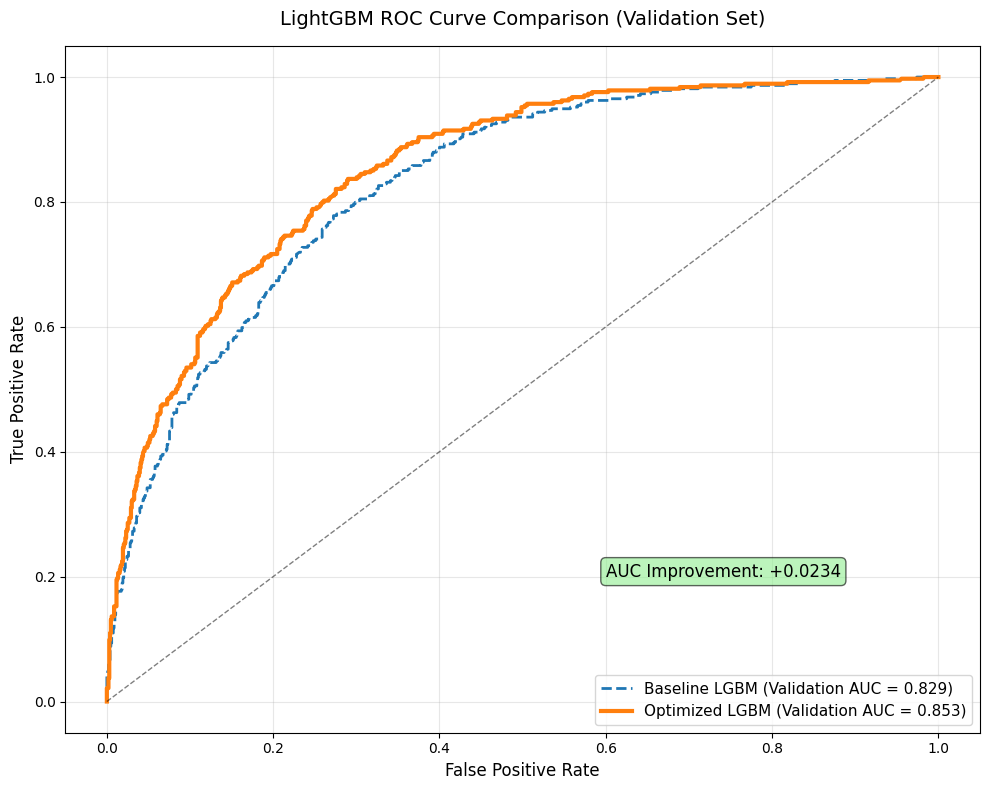

LIGHTGBM VALIDATION RESULTS SUMMARY
Baseline LGBM (Default Params) Validation AUC:  0.82937
Best Model (Grid Search) Validation AUC:        0.85280
Improvement Validation AUC:                    +0.02343 (+2.825%)


In [25]:
# BASELINE LightGBM (default params)
baseline_lgb = lgb.LGBMClassifier(random_state=22)
baseline_lgb.fit(X_train, y_train)
y_val_proba_baseline = baseline_lgb.predict_proba(X_val)[:, 1]

# OPTIMIZED LightGBM (Grid Search best model)
final_model = final_lgb_grid
y_val_proba_optimized = final_model.predict_proba(X_val)[:, 1]

# Calculate validation AUC scores
baseline_auc = roc_auc_score(y_val, y_val_proba_baseline)
optimized_auc = roc_auc_score(y_val, y_val_proba_optimized)

# Plot ROC curves (VALIDATION SET ONLY)
plt.figure(figsize=(10, 8))

# Baseline model ROC
fpr_baseline, tpr_baseline, _ = roc_curve(y_val, y_val_proba_baseline)
plt.plot(
    fpr_baseline, tpr_baseline,
    label=f'Baseline LGBM (Validation AUC = {baseline_auc:.3f})',
    linewidth=2, linestyle='--'
)

# Optimized model ROC
fpr_optimized, tpr_optimized, _ = roc_curve(y_val, y_val_proba_optimized)
plt.plot(
    fpr_optimized, tpr_optimized,
    label=f'Optimized LGBM (Validation AUC = {optimized_auc:.3f})',
    linewidth=3
)

# Random chance line
plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(
    'LightGBM ROC Curve Comparison (Validation Set)',
    fontsize=14,
    pad=15
)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)

# AUC improvement annotation
improvement = optimized_auc - baseline_auc
plt.text(
    0.6, 0.2,
    f'AUC Improvement: +{improvement:.4f}',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.6)
)

plt.tight_layout()
plt.show()

# Print summary
percentage_improvement = (improvement / baseline_auc) * 100
print("LIGHTGBM VALIDATION RESULTS SUMMARY")
print(f"Baseline LGBM (Default Params) Validation AUC:  {baseline_auc:.5f}")
print(f"Best Model (Grid Search) Validation AUC:        {optimized_auc:.5f}")
print(f"Improvement Validation AUC:                    +{improvement:.5f} (+{percentage_improvement:.3f}%)")


# LightGBM – Validation Results

## Validation Metrics

| Model | AUC | Accuracy |
|-------|-----|----------|
| Baseline (Default Params) | 0.82937 | 0.79205 |
| Randomized Search (Validation) | 0.85201 | 0.80696 |
| Grid Search (Validation) | 0.85280 | 0.80837 |
| Grid Search (Validation, Threshold 0.51) | 0.85280 | 0.81050 |

---

## Quick Summary

* **Starting point:** Baseline LightGBM gave a solid AUC of **0.82937**, slightly below Gradient Boosting’s baseline.  
* **Randomized Search** helped find promising hyperparameters, boosting AUC to **0.85201** and Accuracy to **0.80696**.  
* **Grid Search** fine-tuned these candidates, nudging AUC up to **0.85280**, with threshold adjustment (0.51) lifting Accuracy to **0.81050**.  
* **Improvement vs baseline:** noticeable, +0.02343 AUC (+2.83%).

### Conclusion
* LightGBM started a little behind Gradient Boosting in baseline performance but caught up and slightly surpassed it after tuning.  
* Hyperparameter tuning clearly improved the model’s performance and threshold tweaks gave a little extra boost.  
* Overall, LightGBM is **reliable and competitive**, making it a strong candidate before we moved on to XGBoost.


# XGBoost Model
#### XGBoost Randomized Search 
---

<details>
<summary>XGBoost Randomized Search Code & Results (CLICK TO EXPAND)</summary>

```python
# Parameter distribution 
param_dist= {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [3, 4, 5],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8]
}

# Scoring dictionary
scoring = {
    'AUC': 'roc_auc',
    'Accuracy': 'accuracy'
}

# Randomized Search
xgb_random = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=22
    ),
    param_distributions=param_dist,
    n_iter=10,  
    scoring=scoring,
    refit='AUC',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=22
)

# Fit
xgb_random.fit(X_train, y_train)

# Process results
results_df = pd.DataFrame(xgb_random.cv_results_)
cols_to_keep = ['mean_test_AUC', 'mean_test_Accuracy', 'std_test_AUC', 'std_test_Accuracy', 'params']
results_df = results_df[cols_to_keep].sort_values(by='mean_test_AUC', ascending=False)

params_expanded = results_df['params'].apply(pd.Series)
full_results_random = pd.concat([results_df.drop(columns='params'), params_expanded], axis=1)

# Display top 5 Randomized Search results
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
print("\nTop 5 XGBoost Models (Randomized Search by CV AUC):")
print(full_results_random.head(5))

# Best model metrics
best_idx= xgb_random.best_index_
best_auc= xgb_random.cv_results_['mean_test_AUC'][best_idx]
best_acc= xgb_random.cv_results_['mean_test_Accuracy'][best_idx]

print("\nBest CV Results (Randomized Search):")
print(f"  AUC-ROC : {best_auc:.4f}")
print(f"  Accuracy: {best_acc:.4f}")

print("\nBest Parameters:")
for k, v in xgb_random.best_params_.items():
    print(f"  {k}: {v}")

# Validation set evaluation
best_xgb = xgb_random.best_estimator_
y_val_proba = best_xgb.predict_proba(X_val)[:, 1]
y_val_pred = best_xgb.predict(X_val)

final_auc = roc_auc_score(y_val, y_val_proba)
final_acc = accuracy_score(y_val, y_val_pred)

print("\nFinal Validation Results:")
print(f"  AUC-ROC : {final_auc:.4f}")
print(f"  Accuracy: {final_acc:.4f}")

print("\nBest Parameters (for validation model):")
for k, v in xgb_random.best_params_.items():
    print(f"  {k}: {v}")

Output 
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Top 5 XGBoost Models (Randomized Search by CV AUC):
   mean_test_AUC  mean_test_Accuracy  std_test_AUC  std_test_Accuracy  subsample  n_estimators  max_depth  \
6       0.839295            0.800713      0.009622           0.010401        0.8         100.0        5.0   
9       0.838460            0.796689      0.008192           0.010124        0.8         200.0        5.0   
4       0.837894            0.800003      0.007579           0.010517        0.8         300.0        4.0   
5       0.837621            0.797399      0.011275           0.009690        0.6         100.0        5.0   
0       0.837511            0.789114      0.012376           0.006627        0.6         200.0        3.0   

   learning_rate  colsample_bytree  
6           0.05               0.6  
9           0.03               0.6  
4           0.03               0.8  
5           0.01               0.6  
0           0.01               0.6  

Best CV Results (Randomized Search):
  AUC-ROC : 0.8393
  Accuracy: 0.8007

Best Parameters:
  subsample: 0.8
  n_estimators: 100
  max_depth: 5
  learning_rate: 0.05
  colsample_bytree: 0.6

Final Validation Results:
  AUC-ROC : 0.8488
  Accuracy: 0.8070

Best Parameters (for validation model):
  subsample: 0.8
  n_estimators: 100
  max_depth: 5
  learning_rate: 0.05
  colsample_bytree: 0.6


In [26]:
# BEST PARAMETERS (XGBoost Randomized Search)
best_params_xgb = {
    'subsample': 0.8,
    'n_estimators': 100,
    'max_depth': 5,
    'learning_rate': 0.05,
    'colsample_bytree': 0.6,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'random_state': 22
}

# Instantiate and fit final XGBoost Randomized model
final_xgb = xgb.XGBClassifier(**best_params_xgb)
final_xgb.fit(X_train, y_train)

# Validation set predictions
y_val_pred = final_xgb.predict(X_val)
y_val_proba = final_xgb.predict_proba(X_val)[:, 1]

# Validation set metrics
val_auc = roc_auc_score(y_val, y_val_proba)
val_acc = accuracy_score(y_val, y_val_pred)

print("XGBOOST (RANDOMIZED SEARCH) VALIDATION RESULTS")
print(f"Validation AUC:      {val_auc:.5f}")
print(f"Validation Accuracy: {val_acc:.5f}")

XGBOOST (RANDOMIZED SEARCH) VALIDATION RESULTS
Validation AUC:      0.84876
Validation Accuracy: 0.80696


### XGBoost Grid Search CV
---

<details>
<summary>XGBoost Grid Search Code & Results (CLICK TO EXPAND)</summary>

```python

# Narrow the ranges based on top 3 from Randomized Search
top3= full_results_random.head(3)

param_grid= {
    'n_estimators': [int(x) for x in sorted(top3['n_estimators'].unique())],
    'max_depth': [int(x) for x in sorted(top3['max_depth'].unique())],
    'learning_rate': [float(x) for x in sorted(top3['learning_rate'].unique())],
    'subsample': [float(x) for x in sorted(top3['subsample'].unique())],
    'colsample_bytree': [float(x) for x in sorted(top3['colsample_bytree'].unique())]
}

# Grid Search
xgb_grid= GridSearchCV(
    estimator=xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=22
    ),
    param_grid=param_grid,
    scoring='roc_auc',
    refit=True,
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit
xgb_grid.fit(X_train, y_train)

# Process Grid Search results
results_df= pd.DataFrame(xgb_grid.cv_results_)
cols_to_keep= ['mean_test_score', 'std_test_score', 'params']
results_df= results_df[cols_to_keep].sort_values(by='mean_test_score', ascending=False)

params_expanded= results_df['params'].apply(pd.Series)
full_results_grid= pd.concat([results_df.drop(columns='params'), params_expanded], axis=1)

# Display top 3 Grid Search results
print("\nTop 3 XGBoost Models (Grid Search by CV AUC):")
print(full_results_grid.head(3))

# Best model metrics
best_idx= xgb_grid.best_index_
best_auc= xgb_grid.cv_results_['mean_test_score'][best_idx]

print("\nBest CV Results (Grid Search):")
print(f"  AUC-ROC : {best_auc:.4f}")

print("\nBest Parameters:")
for k, v in xgb_grid.best_params_.items():
    print(f"  {k}: {v}")

# Validation set evaluation
best_xgb= xgb_grid.best_estimator_
y_val_proba= best_xgb.predict_proba(X_val)[:, 1]
y_val_pred= best_xgb.predict(X_val)

final_auc= roc_auc_score(y_val, y_val_proba)
final_acc= accuracy_score(y_val, y_val_pred)

print("\nFinal Validation Results:")
print(f"  AUC-ROC : {final_auc:.4f}")
print(f"  Accuracy: {final_acc:.4f}")

print("\nBest Parameters (for validation model):")
for k, v in xgb_grid.best_params_.items():
    print(f"  {k}: {v}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits

Top 3 XGBoost Models (Grid Search by CV AUC):
   mean_test_score  std_test_score  colsample_bytree  learning_rate  max_depth  n_estimators  subsample
7         0.842318        0.009083               0.8           0.03        3.0         200.0        0.8
4         0.841869        0.009156               0.6           0.03        3.0         300.0        0.8
1         0.841864        0.009655               0.6           0.03        3.0         200.0        0.8

Best CV Results (Grid Search):
  AUC-ROC : 0.8423

Best Parameters:
  colsample_bytree: 0.8
  learning_rate: 0.03
  max_depth: 3
  n_estimators: 200
  subsample: 0.8

Final Validation Results:
  AUC-ROC : 0.8529
  Accuracy: 0.8048

Best Parameters (for validation model):
  colsample_bytree: 0.8
  learning_rate: 0.03
  max_depth: 3
  n_estimators: 200
  subsample: 0.8

In [27]:
# BEST PARAMETERS (XGBoost Grid Search)
best_params_xgb_grid = {
    'subsample': 0.8,
    'n_estimators': 200,
    'max_depth': 3,
    'learning_rate': 0.03,
    'colsample_bytree': 0.8,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'random_state': 22
}

# Instantiate and fit final XGBoost Grid Search model
final_xgb_grid = xgb.XGBClassifier(**best_params_xgb_grid)
final_xgb_grid.fit(X_train, y_train)

# Validation set predictions
y_val_pred = final_xgb_grid.predict(X_val)
y_val_proba = final_xgb_grid.predict_proba(X_val)[:, 1]

# Validation set metrics
val_auc = roc_auc_score(y_val, y_val_proba)
val_acc = accuracy_score(y_val, y_val_pred)

print("XGBOOST (GRID SEARCH) VALIDATION RESULTS")
print(f"Validation AUC:      {val_auc:.5f}")
print(f"Validation Accuracy: {val_acc:.5f}")

XGBOOST (GRID SEARCH) VALIDATION RESULTS
Validation AUC:      0.85294
Validation Accuracy: 0.80483


#### XGBoost Threshold
---

In [28]:
# Baseline XGBoost (default params)
baseline_xgb = xgb.XGBClassifier(random_state=22, use_label_encoder=False, eval_metric='logloss')
baseline_xgb.fit(X_train, y_train)

# Baseline validation predictions
y_val_pred_baseline = baseline_xgb.predict(X_val)
y_val_proba_baseline = baseline_xgb.predict_proba(X_val)[:, 1]

# Baseline validation metrics
baseline_val_acc = accuracy_score(y_val, y_val_pred_baseline)
baseline_val_auc = roc_auc_score(y_val, y_val_proba_baseline)

# Threshold Tuning / Optimized Model
best_xgb = final_xgb_grid  

# Validation set probabilities
y_val_probs = best_xgb.predict_proba(X_val)[:, 1]

# Find best threshold on validation set
thresholds = np.arange(0.35, 0.65, 0.01)
for t in thresholds:
    y_pred_thresh = (y_val_probs >= t).astype(int)
    acc = accuracy_score(y_val, y_pred_thresh)
    print(f"Threshold: {t:.2f} || Accuracy: {acc:.5f}")

best_threshold = 0.45  

# Optimized model validation predictions
y_val_pred_default = best_xgb.predict(X_val)
y_val_pred_optimized = (y_val_probs >= best_threshold).astype(int)

# Validation set metrics for optimized model
val_auc = roc_auc_score(y_val, y_val_probs)
val_acc_default = accuracy_score(y_val, y_val_pred_default)
val_acc_optimized = accuracy_score(y_val, y_val_pred_optimized)

# Print Final Validation Results
print()
print("VALIDATION RESULTS XGBOOST")
print(f"Baseline (default params) Validation AUC:                    {baseline_val_auc:.5f}")
print(f"Baseline (default params) Validation Accuracy:               {baseline_val_acc:.5f}")
print(f"Best Model Validation AUC (Grid Search):                     {val_auc:.5f}")
print(f"Best Model Validation Accuracy (Grid Search) (0.5):          {val_acc_default:.5f}")
print(f"Best Model Validation Accuracy (Grid Search) ({best_threshold:.2f}):         {val_acc_optimized:.5f}")


Threshold: 0.35 || Accuracy: 0.79489
Threshold: 0.36 || Accuracy: 0.80128
Threshold: 0.37 || Accuracy: 0.80483
Threshold: 0.38 || Accuracy: 0.80625
Threshold: 0.39 || Accuracy: 0.80199
Threshold: 0.40 || Accuracy: 0.80341
Threshold: 0.41 || Accuracy: 0.79986
Threshold: 0.42 || Accuracy: 0.80341
Threshold: 0.43 || Accuracy: 0.80696
Threshold: 0.44 || Accuracy: 0.81192
Threshold: 0.45 || Accuracy: 0.81263
Threshold: 0.46 || Accuracy: 0.81121
Threshold: 0.47 || Accuracy: 0.80767
Threshold: 0.48 || Accuracy: 0.80483
Threshold: 0.49 || Accuracy: 0.80199
Threshold: 0.50 || Accuracy: 0.80483
Threshold: 0.51 || Accuracy: 0.80483
Threshold: 0.52 || Accuracy: 0.80554
Threshold: 0.53 || Accuracy: 0.80979
Threshold: 0.54 || Accuracy: 0.80837
Threshold: 0.55 || Accuracy: 0.80767
Threshold: 0.56 || Accuracy: 0.80625
Threshold: 0.57 || Accuracy: 0.80270
Threshold: 0.58 || Accuracy: 0.80199
Threshold: 0.59 || Accuracy: 0.80128
Threshold: 0.60 || Accuracy: 0.79773
Threshold: 0.61 || Accuracy: 0.79418
T

#### "Before and After" ROC Curve Comparison XGBoost
---

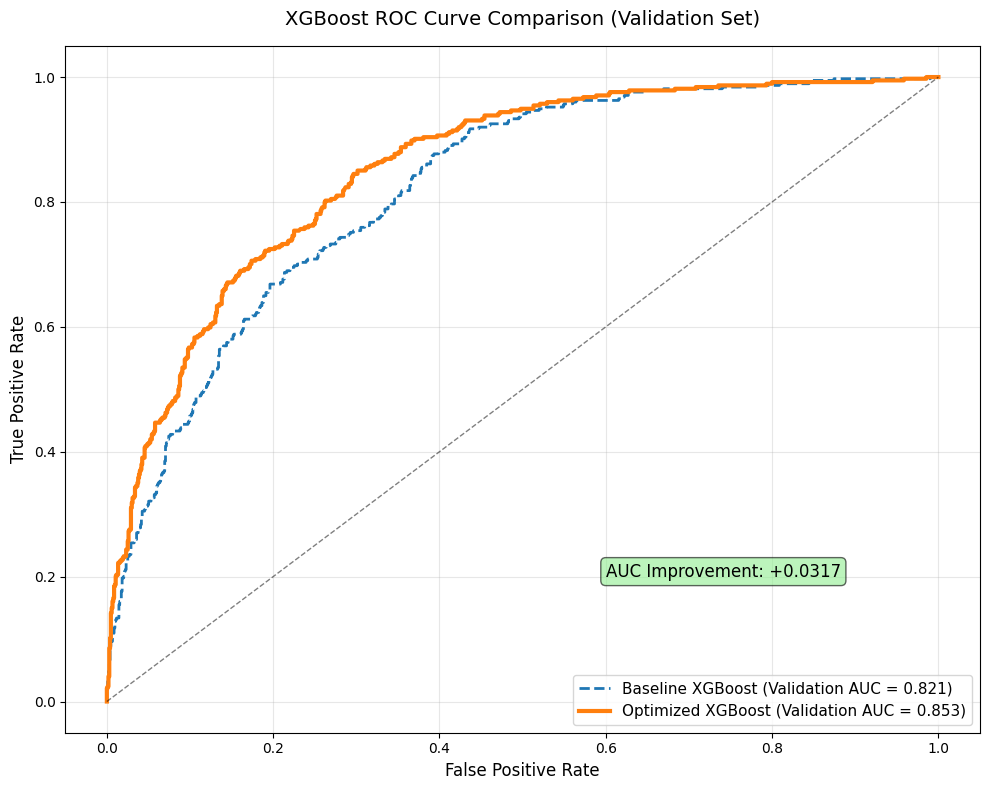

XGBOOST VALIDATION RESULTS SUMMARY
Baseline XGBoost (Default Params) Validation AUC:  0.82126
Best Model (Grid Search) Validation AUC:           0.85294
Improvement Validation AUC:                       +0.03168 (+3.857%)


In [29]:
# BASELINE XGBoost (default params)
baseline_xgb = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=22
)
baseline_xgb.fit(X_train, y_train)
y_val_proba_baseline = baseline_xgb.predict_proba(X_val)[:, 1]

# OPTIMIZED XGBoost (Grid Search best model)
final_model = final_xgb_grid
y_val_proba_optimized = final_model.predict_proba(X_val)[:, 1]

# Calculate validation AUC scores
baseline_auc = roc_auc_score(y_val, y_val_proba_baseline)
optimized_auc = roc_auc_score(y_val, y_val_proba_optimized)

# Plot ROC curves (VALIDATION SET ONLY)
plt.figure(figsize=(10, 8))

# Baseline model ROC
fpr_baseline, tpr_baseline, _ = roc_curve(y_val, y_val_proba_baseline)
plt.plot(
    fpr_baseline, tpr_baseline,
    label=f'Baseline XGBoost (Validation AUC = {baseline_auc:.3f})',
    linewidth=2, linestyle='--'
)

# Optimized model ROC
fpr_optimized, tpr_optimized, _ = roc_curve(y_val, y_val_proba_optimized)
plt.plot(
    fpr_optimized, tpr_optimized,
    label=f'Optimized XGBoost (Validation AUC = {optimized_auc:.3f})',
    linewidth=3
)

# Random chance line
plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(
    'XGBoost ROC Curve Comparison (Validation Set)',
    fontsize=14,
    pad=15
)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)

# AUC improvement annotation
improvement = optimized_auc - baseline_auc
plt.text(
    0.6, 0.2,
    f'AUC Improvement: +{improvement:.4f}',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.6)
)

plt.tight_layout()
plt.show()

# Print summary
percentage_improvement = (improvement / baseline_auc) * 100
print("XGBOOST VALIDATION RESULTS SUMMARY")
print(f"Baseline XGBoost (Default Params) Validation AUC:  {baseline_auc:.5f}")
print(f"Best Model (Grid Search) Validation AUC:           {optimized_auc:.5f}")
print(f"Improvement Validation AUC:                       +{improvement:.5f} (+{percentage_improvement:.3f}%)")


# XGBoost – Validation Results

## Validation Metrics

| Model | AUC | Accuracy |
|-------|-----|----------|
| Baseline (Default Params) | 0.82126 | 0.78353 |
| Randomized Search (Validation) | 0.84876 | 0.80696 |
| Grid Search (Validation) | 0.85294 | 0.80483 |
| Grid Search (Validation, Threshold 0.45) | 0.85294 | 0.81263 |

---

## Quick Summary

* **Baseline XGBoost** started a little behind Gradient Boosting and LightGBM in AUC, at **0.82126**.  
* **Randomized Search** found promising hyperparameters, lifting AUC to **0.84876** and Accuracy to **0.80696**—already competitive with the other tuned models.  
* **Grid Search** fine-tuned the top candidates, achieving **Validation AUC = 0.85294**, with threshold adjustment (0.45) giving a small Accuracy boost to **0.81263**.  
* **Improvement vs baseline:** largest among all models, +0.03168 AUC (+3.857%).

### Conclusion
* XGBoost’s baseline was modest, but tuning really paid off, surpassing the other models after optimization.  
* Hyperparameter tuning, especially with careful threshold adjustment, gave **the most significant gains**.  
* Overall, XGBoost proved to be the **best-performing and most robust model**, making it the natural choice for final testing and deployment.


# Best Model Selection & Final Test with Roc Journey
---

In [34]:
# Combine train + validation sets
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

# Refit best XGBoost model on full training data
final_xgb = xgb.XGBClassifier(**best_params_xgb_grid)
final_xgb.fit(X_train_full, y_train_full)

# Test set predictions
y_test_pred = final_xgb.predict(X_test)
y_test_proba = final_xgb.predict_proba(X_test)[:, 1]

# Test metrics
test_auc = roc_auc_score(y_test, y_test_proba)
test_acc = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("XGBOOST (FINAL TEST SET RESULTS)")
print(f"Test AUC:       {test_auc:.5f}")
print(f"Test Accuracy:  {test_acc:.5f}")
print(f"Test Precision: {test_precision:.5f}")
print(f"Test Recall:    {test_recall:.5f}")
print(f"Test F1-score:  {test_f1:.5f}")

XGBOOST (FINAL TEST SET RESULTS)
Test AUC:       0.85628
Test Accuracy:  0.81618
Test Precision: 0.70909
Test Recall:    0.52139
Test F1-score:  0.60092


In [35]:
# Evaluated model performance using an optimized threshold (just to see)
# Use the optimized threshold on test set
optimized_threshold = 0.45
y_test_pred_optimized = (y_test_proba >= optimized_threshold).astype(int)

# Calculate metrics with optimized threshold
test_acc_optimized = accuracy_score(y_test, y_test_pred_optimized)
test_precision_optimized = precision_score(y_test, y_test_pred_optimized)
test_recall_optimized = recall_score(y_test, y_test_pred_optimized)
test_f1_optimized = f1_score(y_test, y_test_pred_optimized)

print("XGBOOST TEST RESULTS - OPTIMIZED THRESHOLD (0.45)")
print(f"Test AUC:       {test_auc:.5f}")  # AUC stays the same
print(f"Test Accuracy:  {test_acc_optimized:.5f}")
print(f"Test Precision: {test_precision_optimized:.5f}")
print(f"Test Recall:    {test_recall_optimized:.5f}")
print(f"Test F1-score:  {test_f1_optimized:.5f}")

XGBOOST TEST RESULTS - OPTIMIZED THRESHOLD (0.45)
Test AUC:       0.85628
Test Accuracy:  0.81618
Test Precision: 0.67802
Test Recall:    0.58556
Test F1-score:  0.62841


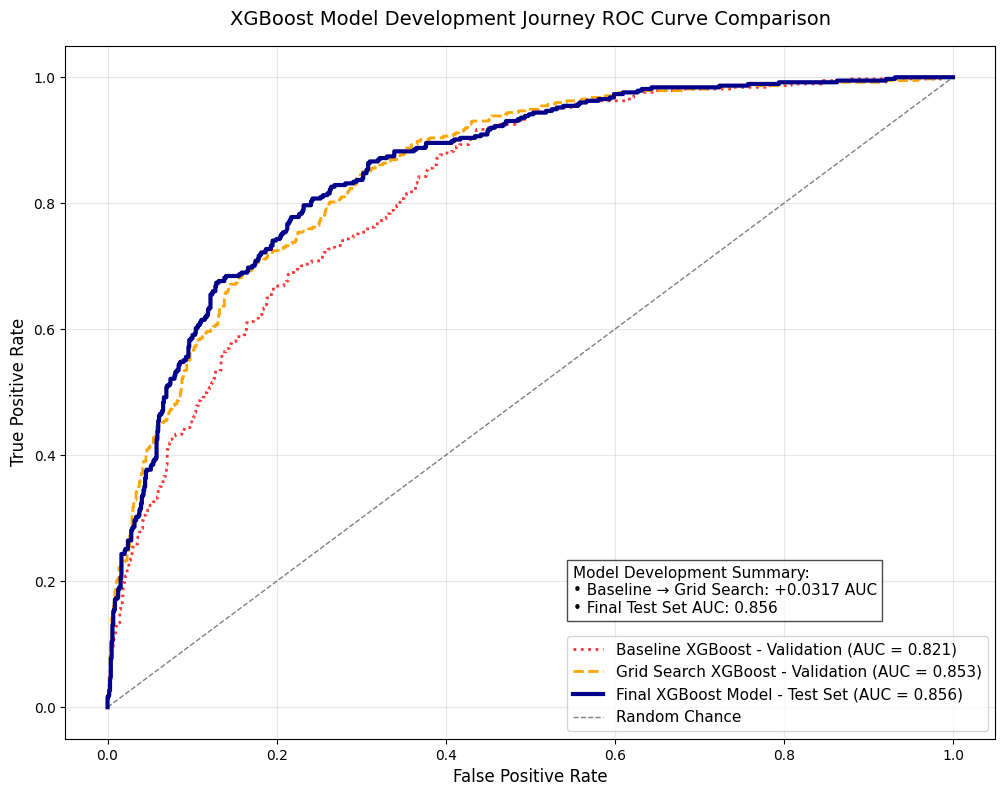

In [39]:
# Create comprehensive final ROC curve showing the full XGBoost journey
plt.figure(figsize=(12, 9))

# 1. BASELINE XGBoost (default params) - Validation Set
baseline_xgb = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=22
)
baseline_xgb.fit(X_train, y_train)
y_val_proba_baseline = baseline_xgb.predict_proba(X_val)[:, 1]
baseline_val_auc = roc_auc_score(y_val, y_val_proba_baseline)

# GRID SEARCH XGBoost - Validation Set
grid_search_xgb = xgb.XGBClassifier(**best_params_xgb_grid)
grid_search_xgb.fit(X_train, y_train)
y_val_proba_grid = grid_search_xgb.predict_proba(X_val)[:, 1]
grid_val_auc = roc_auc_score(y_val, y_val_proba_grid)

# FINAL MODEL - Test Set (already calculated)
final_test_auc = roc_auc_score(y_test, y_test_proba)

# Plot all three ROC curves
# Baseline XGBoost (Validation)
fpr_baseline, tpr_baseline, _ = roc_curve(y_val, y_val_proba_baseline)
plt.plot(
    fpr_baseline, tpr_baseline,
    linewidth=2, linestyle=':', color='red', alpha=0.8,
    label=f'Baseline XGBoost - Validation (AUC = {baseline_val_auc:.3f})'
)

# Grid Search XGBoost (Validation)
fpr_grid, tpr_grid, _ = roc_curve(y_val, y_val_proba_grid)
plt.plot(
    fpr_grid, tpr_grid,
    linewidth=2, linestyle='--', color='orange',
    label=f'Grid Search XGBoost - Validation (AUC = {grid_val_auc:.3f})'
)

# Final Model (Test Set)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
plt.plot(
    fpr_test, tpr_test,
    linewidth=3, color='darkblue',
    label=f'Final XGBoost Model - Test Set (AUC = {final_test_auc:.3f})'
)

# Random chance line
plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5, label='Random Chance')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('XGBoost Model Development Journey ROC Curve Comparison', fontsize=14, pad=15)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)

# Add comprehensive performance annotation
improvement_validation = grid_val_auc - baseline_val_auc
plt.text(
    0.55, 0.15,
    f'Model Development Summary:\n'
    f'• Baseline → Grid Search: +{improvement_validation:.4f} AUC\n'
    f'• Final Test Set AUC: {final_test_auc:.3f}',
    fontsize=11, bbox=dict(facecolor='white', alpha=0.7)
)

plt.show()


## Final Model Comparison & Test Results
---

#### How We Tuned the Models
We used a two-step approach to find the best hyperparameters:

- **Randomized Search:** Ran a broad search across many combinations to quickly spot promising regions.  
  - Top 10 combinations for most models were kept for further evaluation.  
  - For XGBoost (longer training time), we focused on the top 3.  

- **Grid Search:** Took the top candidates from Randomized Search and ran a more detailed search to fine-tune parameters.  

> Randomized Search narrowed the search space, and Grid Search polished the top contenders to get the best final model.

---

### 1. Baseline Performance
- Logistic Regression was a solid baseline (AUC: 0.840), but boosting models had more potential.  
- Gradient Boosting, LightGBM, and XGBoost had baseline AUCs of 0.8503, 0.8294, and 0.8213, respectively.

| Model                | AUC    | Accuracy | Precision | Recall  | F1     |
|---------------------|--------|---------|-----------|--------|--------|
| Logistic Regression  | 0.8400 | 0.8070  | 0.6771    | 0.5214 | 0.5891 |
| Gradient Boosting    | 0.8503 | 0.8055  | 0.6894    | 0.4866 | 0.5705 |
| <mark>XGBoost</mark> | 0.8213 | 0.7835  | 0.6169    | 0.4866 | 0.5441 |
| LightGBM             | 0.8294 | 0.7921  | 0.6392    | 0.4973 | 0.5594 |

---

### 2. Hyperparameter Tuning
- Gradient Boosting showed a small bump (+0.21%) with Randomized Search.  
- LightGBM improved more (+2.83%) after Grid Search.  
- XGBoost showed the most significant improvement (+3.86%), reaching **Validation AUC: 0.85294**.  
  - Likely due to tuning learning rate, tree depth, and regularization parameters.

| Best Model                | Best Params AUC | Best Params Accuracy | Improvement vs Baseline |
|----------------------------|----------------|-------------------|------------------------|
| Gradient Boosting (Randomized Search) | 0.8521 | 0.8077 | +0.00178 (+0.21%) |
| LightGBM (Grid Search)     | 0.8528         | 0.8084             | +0.02343 (+2.83%)      |
| <mark>XGBoost (Grid Search)</mark>   | <mark>0.85294</mark>  | <mark>0.8048</mark> | <mark>+0.03168 (+3.86%)</mark> |

> XGBoost had the highest AUC improvement, so it became the final choice.

---

### 3. Final Test Set Performance (XGBoost)

| Model / Threshold           | AUC    | Accuracy | Precision | Recall  | F1     |
|-----------------------------|--------|---------|-----------|--------|--------|
| Baseline XGBoost (default)  | 0.8213 | 0.7835  | 0.6169    | 0.4866 | 0.5441 |
| Final XGBoost (0.50)        | 0.8563 | 0.8162  | 0.7091    | 0.5214 | 0.6009 |
| Final XGBoost (0.45*)       | 0.8563 | 0.8162  | 0.6780    | 0.5856 | 0.6284 |

* Lower threshold (0.45) is optional. It increases recall and F1 slightly while keeping AUC/accuracy stable—useful if catching more positives matters.

---

### 4. Business Context / Practical Takeaways
- **<mark>XGBoost</mark>** is the clear winner based on validation AUC and final test metrics.  
- Hyperparameter tuning significantly improved performance, especially for XGBoost.  
- Threshold tuning gives flexibility: 0.50 for balanced metrics, 0.45 to catch more churners.  
- **AUC of 0.856** means the model correctly distinguishes between churners and non-churners ~86% of the time.
- Using a single XGBoost model is simpler to maintain and explain to stakeholders, and it performs as well as more complex ensembles.

### Feature Insights
- Feature engineering contributed meaningfully to performance:  
  - **charges_per_month**, **cost_per_service**, and **contract_payment_interaction** were among the top features in boosting models.  
  - Contract type and high-risk payment patterns (Electronic check) were consistently important.  
  - Service count and usage indicators also helped the models capture churn risk.
- Understanding feature importance helps translate predictions into actionable business recommendations:
  - Ex: customers on short-term contracts or with high-risk payments could be targeted for retention campaigns.

> `note` We tried combining models with an ensemble, but it barely improved AUC (+0.0006). The improvement was negligible, so sticking with XGBoost alone keeps things simple and effective.
